In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from collections import OrderedDict

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv("reviews.csv",encoding='ISO-8859-1') # dataset

In [28]:
df.head() # headers of dataset

,itemid,username,userid,ctime,rating,comment,fakeornot
0,22340582157,freezemip,99459454,1698928810,5,Colour:black Material Quality:ok2 Item receiv...,original
1,22340582157,alcharlie,446791503,1700218136,4,Colour:white and black strip Material Quality:...,original
2,22340582157,exi5t,117767258,1697855946,1,Material Quality:very bad quality even the sc...,original
3,22340582157,a*****n,110405626,1699258588,3,Colour:ok Material Quality:good Come differen...,original
4,22340582157,p*****4,473727561,1703161511,4,Colour:Ok Material Quality:ok Shoes were not ...,original


In [29]:
df.isna().sum() # look for None values and delete them

itemid       0
username     0
userid       0
ctime        0
rating       0
comment      0
fakeornot    0
dtype: int64

In [30]:
df['comment'] = df.apply(lambda row: str(row['comment']).lower(), axis=1) # lowercase
tokenizer = RegexpTokenizer(r'\w+')
df['comment'] = df['comment'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x))) # remove punctuation but word tokenization


In [31]:
df['review_length'] = df['comment'].apply(lambda x: len(x.split())) # review word count

In [32]:
df['date'] = pd.to_datetime(df['ctime'],unit='s').dt.date #date column
df['time'] = pd.to_datetime(df['ctime'],unit='s').dt.time # time column

In [33]:
mnr_df1 = df[['userid', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'userid']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max() #finds the number of reviews made in 1 day/number of reviews ever made by this user
df = df.merge(mnr_df2, on=['userid', 'date'], how='inner')

In [34]:
review_data = df
res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].userid in res:
        res[row[1].userid].append(row[1].comment) #add comment to existing user
    else:
        res[row[1].userid] = [row[1].comment] # new user

individual_reviewer = [{'userid': k, 'comment': v} for k, v in res.items()]
df2 = dict()
df2['userid'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['comment'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just 1 review
    if max == -np.inf:
        max = 0
    df2['userid'][count] = reviewer_data['userid']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['userid', 'Maximum Content Similarity'])

df = pd.merge(review_data, df3, on="userid", how="left")
df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True) #merge df and df3

df.drop(['itemid', 'userid', 'username', 'ctime', 'rating', 'comment'], axis=1, inplace=True) # remove anything that is not relevant


<ipython-input-34-b4b92fa72273>:13: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['userid'] = pd.Series([])
<ipython-input-34-b4b92fa72273>:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


In [35]:
X = df[['review_length', 'mnr', 'Maximum Content Similarity']]
y = df['fakeornot']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) #dataset training

In [38]:
c_val = [0.75, 1, 2, 3, 4, 5, 10]

for c in c_val:
    logreg = LogisticRegression(C=c)
    logreg.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, logreg.predict(X_test))))

Accuracy for C=0.75: 0.9041095890410958
Accuracy for C=1: 0.9178082191780822
Accuracy for C=2: 0.9178082191780822
Accuracy for C=3: 0.9178082191780822
Accuracy for C=4: 0.9178082191780822
Accuracy for C=5: 0.9178082191780822
Accuracy for C=10: 0.9178082191780822


In [39]:
confusionMatrix = confusion_matrix(y_test, logreg.predict(X_test)) #TN FP FN TP
confusionMatrix

array([[ 8,  6],
       [ 0, 59]])

<Axes: xlabel='Predicted', ylabel='Actual'>

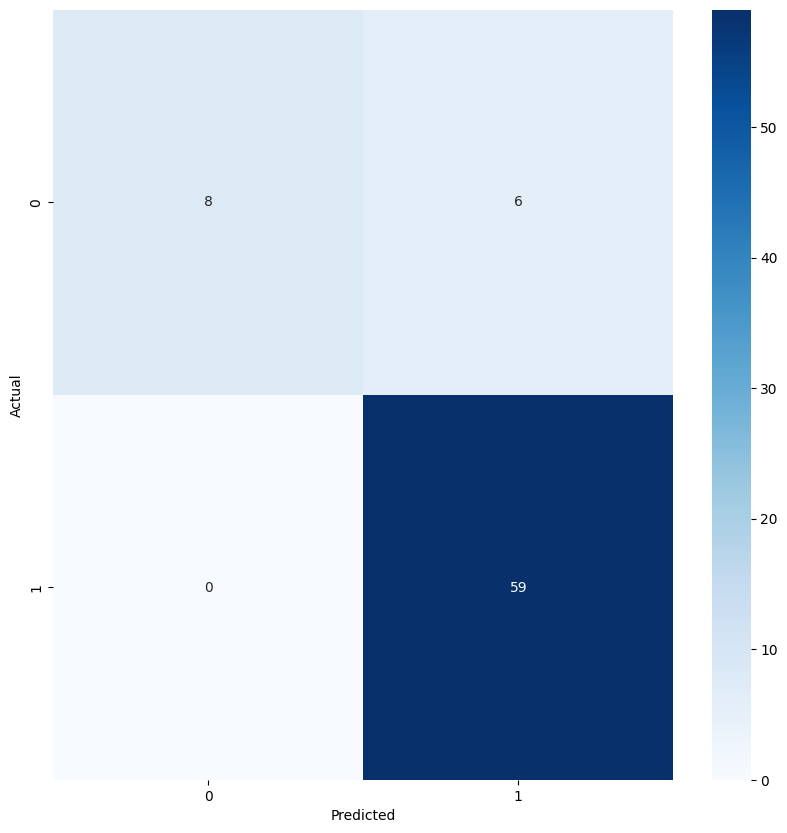

In [40]:
confusionMatrix = pd.DataFrame(confusionMatrix, index=[0,1], columns=[0,1])
confusionMatrix.index.name = 'Actual'
confusionMatrix.columns.name = 'Predicted'

plt.figure(figsize = (10,10))
sns.heatmap(confusionMatrix, cmap= "Blues",annot = True, fmt='')

In [41]:
predicted = logreg.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test, predicted)))
print('Precision Score : ' + str(precision_score(y_test, predicted, pos_label="original")))
print('Recall Score : ' + str(recall_score(y_test, predicted, pos_label="original"))) #correctly predicted positive instances to all actual positive instances.
print('F1 Score : ' + str(f1_score(y_test, predicted, pos_label="original"))) #balance between precision and recall

Accuracy Score : 0.9178082191780822
Precision Score : 0.9076923076923077
Recall Score : 1.0
F1 Score : 0.9516129032258065


In [43]:
test = pd.read_csv("reviews.csv", encoding='ISO-8859-1')

In [45]:
test['comment'] = test.apply(lambda row: str(row['comment']).lower(), axis=1)
# Preprocessing
# Remove Punctuations
tokenizer = RegexpTokenizer(r'\w+')
test['comment'] = test['comment'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))
# Feature Engineering
test['review_length'] = test['comment'].apply(lambda x: len(x.split()))

# Convert UNIX timestamp to date and time
test['date'] = pd.to_datetime(test['ctime'],unit='s').dt.date
test['time'] = pd.to_datetime(test['ctime'],unit='s').dt.time

# Maximum Number of Reviews per day per reviewer
mnr_df1 = test[['userid', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'userid']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
test = test.merge(mnr_df2, on=['userid', 'date'], how='inner')
# Cosine Similarity
review_data = test
res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].userid in res:
        res[row[1].userid].append(row[1].comment)
    else:
        res[row[1].userid] = [row[1].comment]

individual_reviewer = [{'userid': k, 'comment': v} for k, v in res.items()]
df2 = dict()
df2['userid'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['comment'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just one review
    if max == -np.inf:
        max = 0
    df2['userid'][count] = reviewer_data['userid']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['userid', 'Maximum Content Similarity'])
# left outer join on original datamatrix and cosine dataframe
test = pd.merge(review_data, df3, on="userid", how="left")
df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)

logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)

<ipython-input-45-9ac77adf95b2>:31: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['userid'] = pd.Series([])
<ipython-input-45-9ac77adf95b2>:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


LogisticRegression(C=10)

In [46]:
test['fakeornot'] = 'none' #changing fakeornot to none so can reassign

In [48]:
test.head()

,itemid,username,userid,ctime,rating,comment,fakeornot,review_length,date,time,mnr,Maximum Content Similarity
0,22340582157,freezemip,99459454,1698928810,5,colour black material quality ok2 item receive...,original,14,2023-11-02,12:40:10,1.0,1.0
1,22340582157,freezemip,99459454,1698928810,5,colour black material quality ok2 item receive...,original,14,2023-11-02,12:40:10,1.0,1.0
2,22340582157,alcharlie,446791503,1700218136,4,colour white and black strip material quality ...,original,16,2023-11-17,10:48:56,1.0,1.0
3,22340582157,alcharlie,446791503,1700218136,4,colour white and black strip material quality ...,original,16,2023-11-17,10:48:56,1.0,1.0
4,22340582157,exi5t,117767258,1697855946,1,material quality very bad quality even the sch...,original,14,2023-10-21,02:39:06,1.0,1.0


In [49]:
fake = test.fakeornot.str.count("fake").sum()
original = test.fakeornot.str.count("original").sum()

print(fake)
print(original)

33
210


In [ ]:
test['comment'].loc[(test.fakeornot == 'fake')]

In [51]:
test['comment'].loc[(test.fakeornot == 'original')]

0      colour black material quality ok2 item receive...
1      colour black material quality ok2 item receive...
2      colour white and black strip material quality ...
3      colour white and black strip material quality ...
4      material quality very bad quality even the sch...
                             ...                        
238    the attention to detail in the design is truly...
239    perfect for collectors and enthusiasts alike a...
240    the cushioning technology feels like walking o...
241    the nostalgia factor combined with modern tech...
242    no regrets with this purchase jordans are an i...
Name: comment, Length: 210, dtype: object